In [1]:
import os
import sys
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Cropping2D, Flatten, Dense, Lambda, Convolution2D, ELU
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import cv2
import matplotlib.pyplot as plt
import csv
import sklearn
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                fullpath, steering = batch_sample
                center_image = cv2.imread(fullpath)
                center_angle = steering
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)


def read_log_csv(filename):
    lines = []
    with open(filename) as infile:
        reader = csv.DictReader(infile)
        next(reader, None)
        for line in reader:
            lines.append(line)
    return lines

def show_model_summary(model):
    model.summary()
    for layer in model.layers:
        print(layer.output_shape)


In [4]:
def make_model():
    model = Sequential()

    # set up cropping2D layer
    model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))

    #normalize color data to center on zero with mean variance of 1
    model.add(Lambda(lambda x: (x / 255.0) - 0.5))

    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(48, 3, 3, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(128, 3, 3, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(3840))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(100))
    model.add(ELU())

    #a single float output for steering command
    model.add(Dense(1))

    #choose a loss function and optimizer
    model.compile(loss='mse', optimizer='adam')

    return model

m = make_model()
show_model_summary(m)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_2 (Cropping2D)        (None, 90, 320, 3)    0           cropping2d_input_2[0][0]         
____________________________________________________________________________________________________
lambda_2 (Lambda)                (None, 90, 320, 3)    0           cropping2d_2[0][0]               
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 45, 160, 24)   1824        lambda_2[0][0]                   
____________________________________________________________________________________________________
elu_8 (ELU)                      (None, 45, 160, 24)   0           convolution2d_6[0][0]            
___________________________________________________________________________________________

In [7]:
def load_csv(filename, data_path):
    ret = []
    factor = 25.0
    lines = read_log_csv(filename)
    for line in lines:
        source_path = line['center']
        filename = os.path.basename(source_path)
        fullpath = os.path.join(data_path, 'IMG', filename)
        steering = float(line['steering'])
        if steering == 0.0:
            continue
        ret.append((fullpath, steering * factor))
    return ret

def load_data(filename, data_path):
    images = []
    measurements = []
    lines = load_csv(filename, data_path)
    for line in lines:
        fullpath, steering = line
        image = cv2.imread(fullpath)
        if image is None:
            continue

        images.append(image)
        measurements.append(steering)

    return np.array(images), np.array(measurements)

def make_generators(filename, data_path):
    lines = load_csv(filename, data_path)
    train_samples, validation_samples = train_test_split(lines, test_size=0.2)
    # compile and train the model using the generator function
    train_generator = generator(train_samples, batch_size=32)
    validation_generator = generator(validation_samples, batch_size=32)
    return train_generator, validation_generator



image shape (160, 320, 3)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_4 (Cropping2D)        (None, 90, 320, 3)    0           cropping2d_input_4[0][0]         
____________________________________________________________________________________________________
lambda_4 (Lambda)                (None, 90, 320, 3)    0           cropping2d_4[0][0]               
____________________________________________________________________________________________________
convolution2d_16 (Convolution2D) (None, 45, 160, 24)   1824        lambda_4[0][0]                   
____________________________________________________________________________________________________
elu_22 (ELU)                     (None, 45, 160, 24)   0           convolution2d_16[0][0]           
_________________________________________________________________

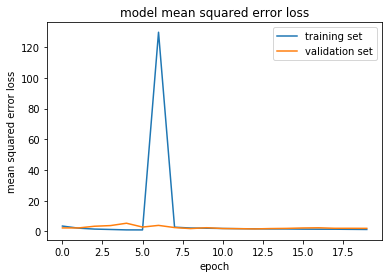

In [8]:
def train():
    data_path = './DriveData'
    cvs_filename = os.path.join(data_path, 'driving_log.csv')

    X_train, y_train = load_data(cvs_filename, data_path)

    print('image shape', X_train[0].shape)

    model = make_model()

    show_model_summary(model)

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=6, verbose=0),
        ModelCheckpoint("model_best.h5", monitor='val_loss', save_best_only=True, verbose=0),
    ]

    history_object = model.fit(X_train, y_train, validation_split=0.2,
        shuffle=True, nb_epoch=20,
        callbacks=callbacks)

    model.save('model.h5')

    # history_object = model.fit_generator(train_generator, samples_per_epoch =
    #     len(train_samples), validation_data = 
    #     validation_generator,
    #     nb_val_samples = len(validation_samples), 
    #     nb_epoch=5, verbose=1)

    ### print the keys contained in the history object
    print(history_object.history.keys())

    ### plot the training and validation loss for each epoch
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

train()